In [1]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, LeakyReLU, Input, ReLU, GlobalAveragePooling2D, Add, Attention, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow_hub as hub

In [20]:
# Define the directory paths
base_dir = "/content/drive/MyDrive/pest/"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
models_dir = os.path.join(base_dir, "models")

# Define the classes
CLASSES = [
    'stem_borer', 'sawfly', 'mosquito', 'mites', 'grasshopper',
    'bollworm', 'beetle', 'armyworm', 'aphids'
]

In [21]:
# Data augmentation and data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Input size compatible with EfficientNetB0
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2700 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


In [22]:
# Load the pre-trained model (EfficientNetB0 from TensorFlow Hub)
MODULE_HANDLE = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
feature_extractor = hub.KerasLayer(MODULE_HANDLE, input_shape=(224, 224, 3), trainable=False)


In [23]:
# Define DeepPestNet CNN model
def create_deeppestnet_custom_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = feature_extractor(inputs)

    # Adding convolutional layers directly on the feature vector
    x = Dense(7 * 7 * 128)(x)
    x = Reshape((7, 7, 128))(x)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (1, 1), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Conv2D(192, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Conv2D(384, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)

    for _ in range(3):
        x = Conv2D(256, (3, 3), padding='same')(x)
        x = LeakyReLU(alpha=0.01)(x)

    # Attention layer
    attention = Attention()([x, x])
    x = Add()([x, attention])

    x = Flatten()(x)
    x = Dense(4096)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    x = Dense(4096)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [24]:
# Create and compile the DeepPestNet model
input_shape = (224, 224, 3)
num_classes = len(CLASSES)
deeppestnet_model = create_deeppestnet_custom_model(input_shape, num_classes)

deeppestnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
deeppestnet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  (None, 1280)                 4049564   ['input_5[0][0]']             
                                                                                                  
 dense (Dense)               (None, 6272)                 8034432   ['keras_layer_2[0][0]']       
                                                                                                  
 reshape_3 (Reshape)         (None, 7, 7, 128)            0         ['dense[0][0]']               
                                                                                              

In [26]:
# Train the model
history = deeppestnet_model.fit(
    train_generator,
    epochs=50,  # Adjust as needed
    validation_data=test_generator
)

Epoch 1/50
85/85 [==============================] - 608s 7s/step - loss: 1.2715 - accuracy: 0.5552 - val_loss: 1.2098 - val_accuracy: 0.6222
Epoch 2/50
85/85 [==============================] - 358s 4s/step - loss: 0.8217 - accuracy: 0.7478 - val_loss: 0.9929 - val_accuracy: 0.7244
Epoch 3/50
85/85 [==============================] - 352s 4s/step - loss: 0.7032 - accuracy: 0.7752 - val_loss: 1.0365 - val_accuracy: 0.7689
Epoch 4/50
85/85 [==============================] - 352s 4s/step - loss: 0.6319 - accuracy: 0.8141 - val_loss: 0.7299 - val_accuracy: 0.7956
Epoch 5/50
85/85 [==============================] - 363s 4s/step - loss: 0.5764 - accuracy: 0.8481 - val_loss: 0.4412 - val_accuracy: 0.8844
Epoch 6/50
85/85 [==============================] - 353s 4s/step - loss: 0.4168 - accuracy: 0.8996 - val_loss: 0.2969 - val_accuracy: 0.9111
Epoch 7/50
85/85 [==============================] - 352s 4s/step - loss: 0.3173 - accuracy: 0.9259 - val_loss: 0.7353 - val_accuracy: 0.8533
Epoch 8/50
85

In [28]:
# Evaluate the model
test_loss, test_acc = deeppestnet_model.evaluate(test_generator)
print(f'DeepPestNet Model Test accuracy: {test_acc}')

# Classification report and confusion matrix
Y_pred_deeppestnet = deeppestnet_model.predict(test_generator)
y_pred_deeppestnet = np.argmax(Y_pred_deeppestnet, axis=1)

print('Classification Report - DeepPestNet Model')
print(classification_report(test_generator.classes, y_pred_deeppestnet, target_names=CLASSES))


15/15 [==============================] - 36s 2s/step - loss: 0.1868 - accuracy: 0.9733
DeepPestNet Model Test accuracy: 0.9733333587646484
15/15 [==============================] - 38s 2s/step
Classification Report - DeepPestNet Model
              precision    recall  f1-score   support

  stem_borer       0.96      1.00      0.98        50
      sawfly       0.96      1.00      0.98        50
    mosquito       1.00      1.00      1.00        50
       mites       0.96      0.94      0.95        50
 grasshopper       1.00      1.00      1.00        50
    bollworm       1.00      0.92      0.96        50
      beetle       1.00      1.00      1.00        50
    armyworm       0.96      0.92      0.94        50
      aphids       0.92      0.98      0.95        50

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



15/15 [==============================] - 63s 4s/step
Classification Report - DeepPestNet Model
              precision    recall  f1-score   support

  stem_borer       0.96      1.00      0.98        50
      sawfly       0.96      1.00      0.98        50
    mosquito       1.00      1.00      1.00        50
       mites       0.96      0.94      0.95        50
 grasshopper       1.00      1.00      1.00        50
    bollworm       1.00      0.92      0.96        50
      beetle       1.00      1.00      1.00        50
    armyworm       0.96      0.92      0.94        50
      aphids       0.92      0.98      0.95        50

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450

Confusion Matrix - DeepPestNet Model


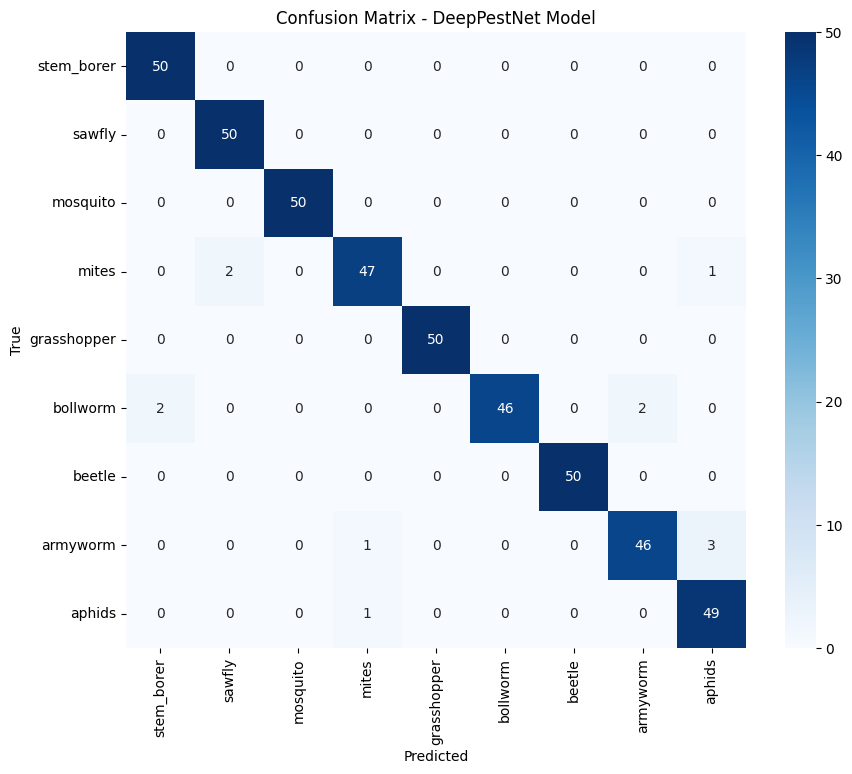

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
# Classification report and confusion matrix
Y_pred_deeppestnet = deeppestnet_model.predict(test_generator)
y_pred_deeppestnet = np.argmax(Y_pred_deeppestnet, axis=1)

print('Classification Report - DeepPestNet Model')
print(classification_report(test_generator.classes, y_pred_deeppestnet, target_names=CLASSES))

print('Confusion Matrix - DeepPestNet Model')
conf_matrix_deeppestnet = confusion_matrix(test_generator.classes, y_pred_deeppestnet)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_deeppestnet, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - DeepPestNet Model')
plt.show()

# Save the DeepPestNet model
deeppestnet_model.save(os.path.join(models_dir, 'deeppestnet_model.h5'))